In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data_path
dir_data = './data/TW'
f_app_train = os.path.join(dir_data, '2020data_pchome1.CSV')
app_train = pd.read_csv(f_app_train)

In [2]:
app_train.head()

,member_id,postal_cd,date_cd,prod_id,goods,department,index,prod_Q,price,MSRP
0,15416142,831,day1,QAAD70-A9006TWM5-000,HP Officejet 7110 A3+ 網路高速印表機,3C,列 印,1,"$6,490",NaN
1,4663689,600,day1,QFAXAS-A900A38S1-001,HappyLife_桌上型微波爐架/烤箱置物架 (YV9799),生活,衛浴,1,$599,NaN
2,8097088,815,day1,QFAAJY-A9009W99R-000,dayneeds_輕型 45x45x160cm 四層電鍍波浪收納鐵架,生活,傢俱,1,$927,"$1,359"
3,15317712,708,day1,QAAS33-A900A7SR4-002,任天堂 Switch Joy-Con 四合一鋁合金 手把充電座(兩色可選),3C,電 玩,1,$690,$990
4,15438512,704,day1,CGAACT-A80423382-005,big5,運動戶外,汽百/記錄器,1,"$1,055","$1,600"


In [3]:
# data processing

# 1. replace MSRP NaN value with price value
# 2. tranform type string to float for price and MSRP column
# 3. price and MSRP multiply prod_Q

import math

price_float = []
MSRP_float = []

for i in app_train.index:
    dollars = app_train['price'][i].replace("$","").replace(",","")
    price_float.append(float(dollars) * app_train['prod_Q'][i])
    if type(app_train['MSRP'][i]) == float:
        if math.isnan(app_train['MSRP'][i]):
            dollars = app_train['price'][i].replace("$","").replace(",","")
            MSRP_float.append(float(dollars) * app_train['prod_Q'][i])
    else:
        dollars = app_train['MSRP'][i].replace("$","").replace(",","")
        MSRP_float.append(float(dollars) * app_train['prod_Q'][i])
        
app_train['price_float'] = price_float
app_train['MSRP_float'] = MSRP_float

app_train = app_train.drop(columns=['MSRP', 'price'])
app_train = app_train.rename(columns={"price_float": "price", "MSRP_float": "MSRP"})

app_train.head()

,member_id,postal_cd,date_cd,prod_id,goods,department,index,prod_Q,price,MSRP
0,15416142,831,day1,QAAD70-A9006TWM5-000,HP Officejet 7110 A3+ 網路高速印表機,3C,列 印,1,6490.0,6490.0
1,4663689,600,day1,QFAXAS-A900A38S1-001,HappyLife_桌上型微波爐架/烤箱置物架 (YV9799),生活,衛浴,1,599.0,599.0
2,8097088,815,day1,QFAAJY-A9009W99R-000,dayneeds_輕型 45x45x160cm 四層電鍍波浪收納鐵架,生活,傢俱,1,927.0,1359.0
3,15317712,708,day1,QAAS33-A900A7SR4-002,任天堂 Switch Joy-Con 四合一鋁合金 手把充電座(兩色可選),3C,電 玩,1,690.0,990.0
4,15438512,704,day1,CGAACT-A80423382-005,big5,運動戶外,汽百/記錄器,1,1055.0,1600.0


In [4]:
# calculate DFM data

# Discount = (1 - monetary_total)/MSRP_total
# Frequency = times of purchase
# Monetary = total of price

df = app_train.copy()

df1 = df.groupby('member_id').agg({'date_cd': np.size})
df2 = df.groupby('member_id')['price'].sum()
df3 = df.groupby('member_id')['MSRP'].sum()

df1['Monetary'] = df2
df1['MSRP_Total'] = df3
df3 = df1.rename(columns={'date_cd':'Frequency'})

discount = []

for i in df3.index:
    discount.append(1 - round(df3['Monetary'][i]/df3['MSRP_Total'][i], 3))

df3['Discount'] = discount

df_DFM = pd.DataFrame()
df_DFM['Discount'] = df3['Discount']
df_DFM['Frequency'] = df3['Frequency']
df_DFM['Monetary'] = df3['Monetary']
df_DFM.to_csv ('DFM.csv', index = False, header=True)
df_DFM.head()

,Discount,Frequency,Monetary
member_id,,,
91,0.000,2,2900.0
549,0.091,1,2090.0
1655,0.147,1,2799.0
2241,0.420,2,1025.0
2988,0.539,2,786.0


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


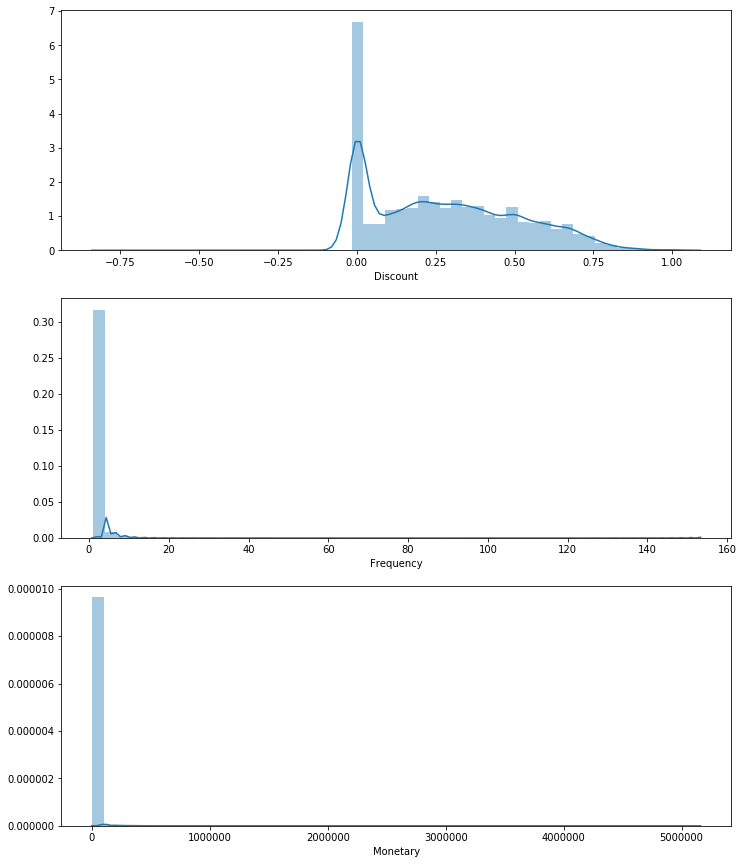

In [5]:
# Plot DFM distributions for probability density

# y-asix is probability density
# Cruve line is gaussian kernel density estimate

plt.figure(figsize=(12,15))
# Plot distribution of D
plt.subplot(3, 1, 1); sns.distplot(df_DFM['Discount'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_DFM['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_DFM['Monetary'])
# Show the plot
plt.show()

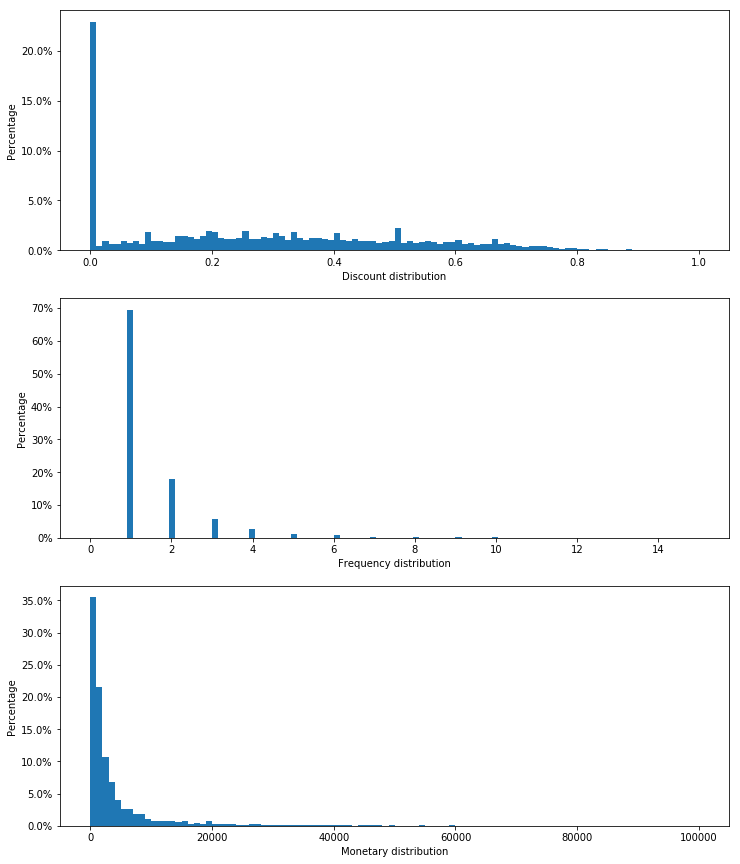

In [6]:
# Plot DFM distributions for probability

# y-asix is probability
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(12,15))
# Plot distribution of D
plt.subplot(3, 1, 1); 
weights = np.ones_like(np.array(df_DFM['Discount']))/float(len(np.array(df_DFM['Discount'])))
plt.xlabel('Discount distribution')
plt.ylabel('Percentage')
plt.hist(df_DFM['Discount'], weights=weights, bins=100, range=(0,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Plot distribution of F
plt.subplot(3, 1, 2);
weights = np.ones_like(np.array(df_DFM['Frequency']))/float(len(np.array(df_DFM['Frequency'])))
plt.xlabel('Frequency distribution')
plt.ylabel('Percentage')
plt.hist(df_DFM['Frequency'], weights=weights, bins=100, range=(0,15))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Plot distribution of M
plt.subplot(3, 1, 3);
weights = np.ones_like(np.array(df_DFM['Monetary']))/float(len(np.array(df_DFM['Monetary'])))
plt.xlabel('Monetary distribution')
plt.ylabel('Percentage')
plt.hist(df_DFM['Monetary'], weights=weights, bins=100, range=(0,100000))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('DFM_Model.pdf')
# Show the plot
plt.show()


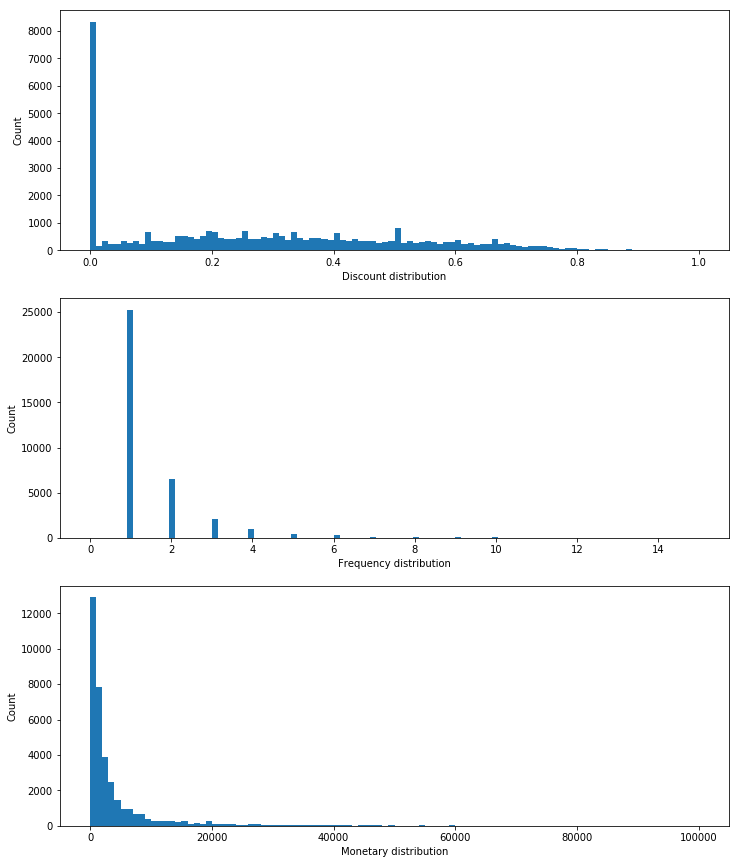

In [7]:
# Plot DFM distributions for count

# y-asix is count

plt.figure(figsize=(12,15))
# Plot distribution of D
plt.subplot(3, 1, 1); 
weights = np.ones_like(np.array(df_DFM['Discount']))
plt.xlabel('Discount distribution')
plt.ylabel('Count')
plt.hist(df_DFM['Discount'], weights=weights, bins=100, range=(0,1))
# Plot distribution of F
plt.subplot(3, 1, 2);
weights = np.ones_like(np.array(df_DFM['Frequency']))
plt.xlabel('Frequency distribution')
plt.ylabel('Count')
plt.hist(df_DFM['Frequency'], weights=weights, bins=100, range=(0,15))
# Plot distribution of M
plt.subplot(3, 1, 3);
weights = np.ones_like(np.array(df_DFM['Monetary']))
plt.xlabel('Monetary distribution')
plt.ylabel('Count')
plt.hist(df_DFM['Monetary'], weights=weights, bins=100, range=(0,100000))
# Show the plot
plt.show()

In [8]:
# Calculate z score

from scipy.stats import zscore

df = df_DFM.apply(zscore)

df_DFM['D_z-score'] = df['Discount']
df_DFM['F_z-score'] = df['Frequency']
df_DFM['M_z-score'] = df['Monetary']
df_DFM.head()

,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score
member_id,,,,,,
91,0.000,2,2900.0,-1.190600,0.160412,-0.085772
549,0.091,1,2090.0,-0.798395,-0.299018,-0.107260
1655,0.147,1,2799.0,-0.557038,-0.299018,-0.088452
2241,0.420,2,1025.0,0.619578,0.160412,-0.135511
2988,0.539,2,786.0,1.132462,0.160412,-0.141851


In [9]:
# calculate VS(Value Score)＝ 1.25*ZD + 1* ZF + 1.5* ZM, Weight of DFM

vsScore = []

for i in df_DFM.index:
    vsScore.append(1.25 * df_DFM['D_z-score'][i] + 1 * df_DFM['F_z-score'][i] + 1.5 * df_DFM['M_z-score'][i])

df_DFM['ValueScore'] = vsScore
df_DFM.head()

,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore
member_id,,,,,,,
91,0.000,2,2900.0,-1.190600,0.160412,-0.085772,-1.456497
549,0.091,1,2090.0,-0.798395,-0.299018,-0.107260,-1.457901
1655,0.147,1,2799.0,-0.557038,-0.299018,-0.088452,-1.127993
2241,0.420,2,1025.0,0.619578,0.160412,-0.135511,0.731617
2988,0.539,2,786.0,1.132462,0.160412,-0.141851,1.363212


In [10]:
# Rank by Value Score

df_DFM['Rank_ValueScore'] = df_DFM['ValueScore'].rank(method='min', ascending=False)
df_DFM_rank = df_DFM.sort_values(by='ValueScore', ascending=False)
result = df_DFM_rank.reset_index()
result.index += 1
result.head()

,member_id,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore
1,2400440,0.000,2,5160000.0,-1.190600,0.160412,136.719082,203.750785,1.0
2,14255682,0.000,132,1084578.0,-1.190600,59.886310,28.608416,101.310685,2.0
3,17871662,0.016,27,2245276.0,-1.121641,11.646161,59.398807,99.342320,3.0
4,16574617,0.000,153,579500.0,-1.190600,69.534340,15.209971,90.861046,4.0
5,14685763,0.011,35,1868927.0,-1.143191,15.321601,49.415217,88.015438,5.0


In [11]:
# Top 20 % valuable customer

valuable = []
for i in result.index:
    if i <= (len(result.index) * 0.2):
        valuable.append('Valuable Customer')
    else:
        valuable.append('Potential Customer')

result['VS_Level'] = valuable

result.to_csv ('DFM_Score.csv', index = False, header=True)

result

,member_id,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore,VS_Level
1,2400440,0.000,2,5160000.0,-1.190600,0.160412,136.719082,203.750785,1.0,Valuable Customer
2,14255682,0.000,132,1084578.0,-1.190600,59.886310,28.608416,101.310685,2.0,Valuable Customer
3,17871662,0.016,27,2245276.0,-1.121641,11.646161,59.398807,99.342320,3.0,Valuable Customer
4,16574617,0.000,153,579500.0,-1.190600,69.534340,15.209971,90.861046,4.0,Valuable Customer
5,14685763,0.011,35,1868927.0,-1.143191,15.321601,49.415217,88.015438,5.0,Valuable Customer
6,11521175,0.025,95,735971.0,-1.082851,42.887400,19.360752,70.574964,6.0,Valuable Customer
7,15651146,0.000,65,519752.0,-1.190600,29.104501,13.625007,48.053762,7.0,Valuable Customer
8,17719417,0.000,2,1146000.0,-1.190600,0.160412,30.237787,44.028843,8.0,Valuable Customer
9,14114293,0.287,55,470590.0,0.046355,24.510201,12.320864,43.049440,9.0,Valuable Customer
10,14875891,0.141,42,475780.0,-0.582897,18.537611,12.458541,36.496801,10.0,Valuable Customer


In [12]:
# Filter top 20% valuable customer

valuableCustomer = result[result.VS_Level != 'Potential Customer']

valuableCustomer

,member_id,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore,VS_Level
1,2400440,0.000,2,5160000.0,-1.190600,0.160412,136.719082,203.750785,1.0,Valuable Customer
2,14255682,0.000,132,1084578.0,-1.190600,59.886310,28.608416,101.310685,2.0,Valuable Customer
3,17871662,0.016,27,2245276.0,-1.121641,11.646161,59.398807,99.342320,3.0,Valuable Customer
4,16574617,0.000,153,579500.0,-1.190600,69.534340,15.209971,90.861046,4.0,Valuable Customer
5,14685763,0.011,35,1868927.0,-1.143191,15.321601,49.415217,88.015438,5.0,Valuable Customer
6,11521175,0.025,95,735971.0,-1.082851,42.887400,19.360752,70.574964,6.0,Valuable Customer
7,15651146,0.000,65,519752.0,-1.190600,29.104501,13.625007,48.053762,7.0,Valuable Customer
8,17719417,0.000,2,1146000.0,-1.190600,0.160412,30.237787,44.028843,8.0,Valuable Customer
9,14114293,0.287,55,470590.0,0.046355,24.510201,12.320864,43.049440,9.0,Valuable Customer
10,14875891,0.141,42,475780.0,-0.582897,18.537611,12.458541,36.496801,10.0,Valuable Customer


In [13]:
# Find Top 20 % valuable customer data

valuableData = pd.DataFrame(data=None, columns=app_train.columns)
for i in valuableCustomer.index:
    df = app_train[app_train.member_id == valuableCustomer['member_id'][i]]
    valuableData = valuableData.append(df, ignore_index=True)
    
prod_Q = []
for i in valuableData.index:
    prod_Q.append(int(valuableData['prod_Q'][i]))

valuableData['prod_Quantity'] = prod_Q
valuableData = valuableData.drop(columns=['prod_Q'])
valuableData = valuableData.rename(columns={'prod_Quantity':'prod_Q'})

SetRank = []

for i in valuableData.index:
    SetRank.append(i + 1)
    
valuableData['Rank'] = SetRank

valuableData = valuableData.reset_index()
valuableData.index += 1
valuableData = valuableData.drop(columns=['level_0'])
valuableData

,member_id,postal_cd,date_cd,prod_id,goods,department,index,price,MSRP,prod_Q,Rank
1,2400440,701,day52,QBAB1D-A900A8Y4I-000,Audio Valve Challenger 400 單聲道後級擴大機,家電,音響劇院,2580000.0,2580000.0,1,1
2,2400440,701,day58,QBAB1D-A900A8Y4I-000,Audio Valve Challenger 400 單聲道後級擴大機,家電,音響劇院,2580000.0,2580000.0,1,2
3,14255682,621,day25,QAAV7O-C900AE0HJ-000,(商用)ASUS TS100-E9 伺服器 自由配,3C,DIY,1528.0,1528.0,1,3
4,14255682,621,day25,QAAV9X-C900AE1EH-000,TS100-E9-E31220V6-2019ESS 機殼+主機板+晶片組,3C,DIY,3131.0,3131.0,1,4
5,14255682,621,day25,QAAV9X-C9008KTLB-000,Intel Xeon E3-1220v6 (3.0 GHz / 8M),3C,DIY,15150.0,15150.0,1,5
6,14255682,621,day25,QAAV9X-C9009F2EM-000,＜加購＞金士頓 8Gx1 DDR4 ECC 記憶體 (標準保留合計8Gx2),3C,DIY,7472.0,7472.0,1,6
7,14255682,621,day25,QAAV9X-C9008L900-000,"＜標準配備＞ASUS原廠 1TBx2 SATA 3.5"" 硬碟",3C,DIY,6060.0,6060.0,1,7
8,14255682,621,day25,QAAV9X-C900AE1DQ-000,＜標準配備＞Windows 2019 Essentials 中文隨機版(送伺服器專用防毒)(...,3C,DIY,15958.0,15958.0,1,8
9,14255682,621,day25,QAAV7O-C900AE0HJ-000,(商用)ASUS TS100-E9 伺服器 自由配,3C,DIY,1528.0,1528.0,1,9
10,14255682,621,day25,QAAV9X-C900AE1EH-000,TS100-E9-E31220V6-2019ESS 機殼+主機板+晶片組,3C,DIY,3131.0,3131.0,1,10


In [14]:
# Sum price group by index 

index = valuableData.groupby(['index']).sum()
index = index.sort_values(by='price', ascending=False)
index = index.reset_index()

top20 = []
for i in index.index:
    if i <= (len(index.index) * 0.2):
        top20.append('Valuable index')
    else:
        top20.append('Potential index')

index['Sales_Rank'] = top20

SetRank = []
for i in index.index:
    SetRank.append(i + 1)
    
index['Rank'] = SetRank

index = index.reset_index()
index.index += 1
index = index.drop(columns=['level_0'])
index.to_csv ('IndexSalesRank.csv', index = False, header=True)
index

,index,price,MSRP,prod_Q,Rank,Sales_Rank
1,機車/部品,11949550.0,12784681.0,250,1,Valuable index
2,預購,10513622.0,18422408.0,810,2,Valuable index
3,筆記電腦,7964847.0,8854817.0,253,3,Valuable index
4,音響劇院,6997385.0,7311803.0,119,4,Valuable index
5,傢俱,6681964.0,16384364.0,2284,5,Valuable index
6,智慧手機,5517482.0,6027506.0,293,6,Valuable index
7,瑞士錶,4511392.0,5168250.0,65,7,Valuable index
8,黃金,3174544.0,3266866.0,126,8,Valuable index
9,液晶電視,3172278.0,9129278.0,168,9,Valuable index
10,燈飾,2546209.0,2722486.0,563,10,Valuable index


In [15]:
# filter top 20 % sales index

valuableSalesIndex = index[index.Sales_Rank != 'Potential index']

SetRank = []

for i in range(1, 33):
    SetRank.append(i)

valuableSalesIndex['Rank'] = SetRank

valuableSalesIndex = valuableSalesIndex.reset_index()
valuableSalesIndex.index += 1
valuableSalesIndex = valuableSalesIndex.drop(columns=['level_0'])

valuableSalesIndex.to_csv ('valuableSalesRank.csv', index = False, header=True)
valuableSalesIndex

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,index,price,MSRP,prod_Q,Rank,Sales_Rank
1,機車/部品,11949550.0,12784681.0,250,1,Valuable index
2,預購,10513622.0,18422408.0,810,2,Valuable index
3,筆記電腦,7964847.0,8854817.0,253,3,Valuable index
4,音響劇院,6997385.0,7311803.0,119,4,Valuable index
5,傢俱,6681964.0,16384364.0,2284,5,Valuable index
6,智慧手機,5517482.0,6027506.0,293,6,Valuable index
7,瑞士錶,4511392.0,5168250.0,65,7,Valuable index
8,黃金,3174544.0,3266866.0,126,8,Valuable index
9,液晶電視,3172278.0,9129278.0,168,9,Valuable index
10,燈飾,2546209.0,2722486.0,563,10,Valuable index


In [16]:
# Filter top 20 % prod_Q group by index 
valuableQuantityIndex = valuableSalesIndex.sort_values(by='prod_Q', ascending=False)
valuableQuantityIndex = valuableQuantityIndex.reset_index()
valuableQuantityIndex.index += 1

top20 = []
for i in valuableQuantityIndex.index:
    if i <= (len(valuableQuantityIndex.index) * 0.2):
        top20.append('Valuable index')
    else:
        top20.append('Potential index')

valuableQuantityIndex['Quantity_Rank'] = top20

SetRank = []
for i in valuableQuantityIndex.index:
    SetRank.append(i)
valuableQuantityIndex['Rank'] = SetRank

valuableQuantityIndex = valuableQuantityIndex.drop(columns=['level_0'])
valuableQuantityIndex.to_csv ('IndexQuantityRank.csv', index = False, header=True)

valuableQuantityIndex

,index,price,MSRP,prod_Q,Rank,Sales_Rank,Quantity_Rank
1,傢俱,6681964.0,16384364.0,2284,1,Valuable index,Valuable index
2,下載,1492896.0,1525725.0,1718,2,Valuable index,Valuable index
3,收納,736620.0,1790765.0,928,3,Valuable index,Valuable index
4,預購,10513622.0,18422408.0,810,4,Valuable index,Valuable index
5,燈飾,2546209.0,2722486.0,563,5,Valuable index,Valuable index
6,餐廚,741347.0,1799720.0,471,6,Valuable index,Valuable index
7,廚房家電,1414375.0,2550179.0,396,7,Valuable index,Potential index
8,衛浴,905104.0,1479166.0,373,8,Valuable index,Potential index
9,三井3C,1080919.0,1419969.0,367,9,Valuable index,Potential index
10,按摩椅/舒壓,1712306.0,4381289.0,339,10,Valuable index,Potential index


In [17]:
# Top 20 % valuable index data

valuableIndex = valuableQuantityIndex[valuableQuantityIndex.Quantity_Rank != 'Potential index']

valuableIndex = valuableIndex.reset_index()
valuableIndex.index += 1
valuableIndex = valuableIndex.drop(columns=['level_0'])

SetRank = []
for i in valuableIndex.index:
    SetRank.append(i)
valuableIndex['Rank'] = SetRank

valuableIndex.to_csv ('Top20ValuableIndex.csv', index = False, header=True)

valuableIndex

,index,price,MSRP,prod_Q,Rank,Sales_Rank,Quantity_Rank
1,傢俱,6681964.0,16384364.0,2284,1,Valuable index,Valuable index
2,下載,1492896.0,1525725.0,1718,2,Valuable index,Valuable index
3,收納,736620.0,1790765.0,928,3,Valuable index,Valuable index
4,預購,10513622.0,18422408.0,810,4,Valuable index,Valuable index
5,燈飾,2546209.0,2722486.0,563,5,Valuable index,Valuable index
6,餐廚,741347.0,1799720.0,471,6,Valuable index,Valuable index
